In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [42]:
# Data preparation function
def prepare_country_stats(oecd_bli, gdp_per_capita):
    """
    Prepare and merge OECD BLI data with GDP per capita data
    Returns: DataFrame with GDP per capita and Life satisfaction metrics
    """
    # Create copies to avoid SettingWithCopyWarning
    oecd_bli_copy = oecd_bli.copy()
    gdp_per_capita_copy = gdp_per_capita.copy()
    
    # Filter the data
    oecd_bli_filtered = oecd_bli_copy[oecd_bli_copy["INEQUALITY"]=="TOT"]
    
    # Pivot the data
    oecd_bli_pivoted = oecd_bli_filtered.pivot(
        index="Country",
        columns="Indicator",
        values="Value"
    )
    
    # Prepare GDP data
    gdp_per_capita_copy.rename(
        columns={"2015": "GDP per capita"},
        inplace=True
    )
    gdp_per_capita_copy.set_index("Country", inplace=True)
    
    # Merge the datasets
    full_country_stats = pd.merge(
        left=oecd_bli_pivoted,
        right=gdp_per_capita_copy,
        left_index=True,
        right_index=True
    )
    
    # Select columns and handle missing values
    required_columns = ["GDP per capita", "Life satisfaction"]
    country_stats = full_country_stats[required_columns].copy()  # Create a copy
    
    # Drop NA values and return
    return country_stats.dropna()  
    

In [52]:
# Load the data
oecd_bli = pd.read_csv("datasets/oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv("datasets/gdp_per_capita.csv",
                            thousands=',',
                            delimiter='\t',  # Tab-separated file
                            encoding='latin1',  # Special encoding for accents
                            na_values="n/a")  # Handle missing values

In [54]:
# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)
X = np.c_[country_stats['GDP per capita']]
y = np.c_[country_stats['Life satisfaction']]

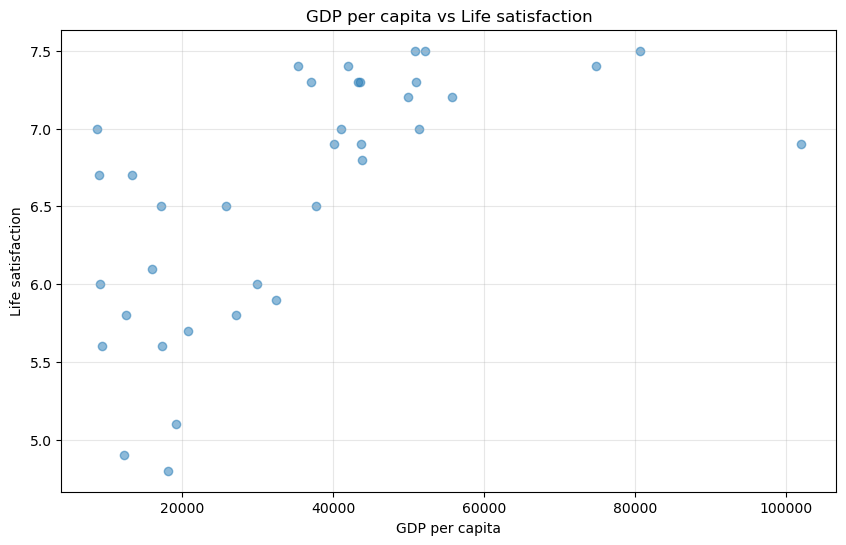

In [60]:
# Visualize the data
plt.figure(figsize=(10,6))
plt.scatter(X, y, alpha=0.5)
plt.xlabel("GDP per capita")
plt.ylabel("Life satisfaction")
plt.title("GDP per capita vs Life satisfaction")
plt.grid(True, alpha=0.3)

In [62]:
# Train the model
model = LinearRegression()
model.fit(X,y)

LinearRegression()

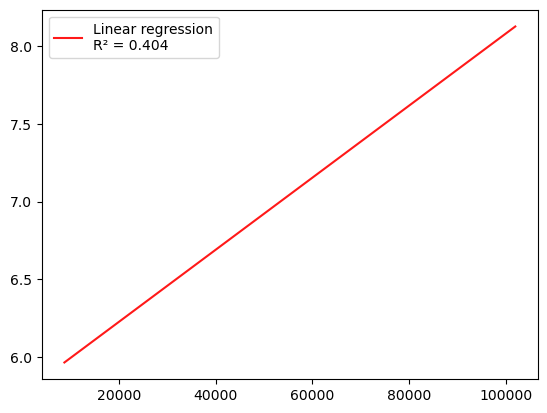

In [71]:
# Add regression line:
# Generate evenly spaced points for smooth line plotting
# np.linspace creates 1000 evenly spaced points between min and max GDP values
# reshape(-1, 1) converts the array to a 2D array required by sklearn
X_new = np.linspace(X.min(), X.max(), 1000).reshape(-1,1)

# Use trained model to predict life satisfaction for these GDP values
# This creates the y-coordinates for our regression line
y_new = model.predict(X_new)

# Plot the regression line
plt.plot(
    X_new, # X coordinates (GDP Values)
    y_new,# Y coordinates (Predicted life satisfaction)
    'r-', # Solid red line
    alpha=0.9,
    label=f'Linear regression\nR² = {model.score(X, y):.3f}' # Label with R² score
)
# Add legend to show R² score
plt.legend()

# Display the plot
plt.show()

In [75]:
# Make prediction for Cyprus
X_new = [[22587]]

# Use model to predict life satisfaction:
cyprus_prediction = model.predict(X_new)

In [79]:
"""
Print formatted prediction
cyprus_prediction[0][0] accesses:
- First (and only) prediction [0]
- First (and only) value in that prediction [0]
:.2f formats to 2 decimal places
"""
print(f"Predicted life satisfaction for Cyprus: {cyprus_prediction[0][0]:.2f}")

Predicted life satisfaction for Cyprus: 6.29


In [83]:
# Model evaluation section
print("\nModel Details:")
# Slope/Coefficient shows the change in life satisfaction per unit change in GDP
print(f"Slope (GDP coefficient): {model.coef_[0][0]:.6f}")
# Intercept is the predicted life satisfaction when GDP = 0
print(f"Intercept: {model.intercept_[0]:.3f}")
# R² (R-squared) indicates how well the model fits the data
# Range is 0 to 1, where 1 means perfect fit
print(f"R² Score: {model.score(X, y):.3f}")



Model Details:
Slope (GDP coefficient): 0.000023
Intercept: 5.763
R² Score: 0.404
